# Chest XRay classification for Pneumonia detection 

The objective of this project is to train a neural network at classifying chest xray as presenting a pneumonia or not. The training, validation and testing dataset used are proposed by Paul Thimoty Mooney on Kaggle : 
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia? 
The code itself is mainly based on a started notebook for advanced transfer learning : https://www.kaggle.com/aakashns/advanced-transfer-learning-starter-notebook

In [2]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

## Data Preparation and data augmentation

The data directory structure (one folder per class) is used by many computer vision datasets, and most deep learning libraries provide utilites for working with such datasets. 

In [3]:
data_dir = '../input/chest-xray-pneumonia/chest_xray'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['chest_xray', '__MACOSX', 'train', 'val', 'test']
['NORMAL', 'PNEUMONIA']


Let's take a look at the training folder and check the number of files.

In [4]:
normal_train_files = os.listdir(data_dir + "/train/NORMAL")
pneumonia_train_files = os.listdir(data_dir + "/train/PNEUMONIA")
normal_val_files = os.listdir(data_dir + "/val/NORMAL")
pneumonia_val_files = os.listdir(data_dir + "/val/PNEUMONIA")
normal_test_files = os.listdir(data_dir + "/test/NORMAL")
pneumonia_test_files = os.listdir(data_dir + "/test/PNEUMONIA")

In [5]:
print('No. of training examples for normal chest xray is:', len(normal_train_files))
print('No. of training examples for pneumonia xray is:', len(pneumonia_train_files))
print(normal_train_files[:5])

No. of training examples for normal chest xray is: 1341
No. of training examples for pneumonia xray is: 3875
['NORMAL2-IM-0569-0001.jpeg', 'NORMAL2-IM-0523-0001.jpeg', 'NORMAL2-IM-1285-0001.jpeg', 'NORMAL2-IM-1262-0001.jpeg', 'NORMAL2-IM-1017-0001.jpeg']


We can use the ImageFolder class from torchvision to load the data as PyTorch tensors.

In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as T

We define a composition of transformations that will allow us to standardize the resolution of the images then load them as Tensors. 

In [7]:
train_transform = T.Compose([
#        T.Resize((512,575)),
        T.Resize((224,224)),
        T.RandomRotation(5),
#TODO        T.Grayscale(num_output_channels=3),
        T.ToTensor()])
#TODO       T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_transform = T.Compose([
        T.Resize((224,224)),  
#TODO        T.Grayscale(num_output_channels=3),
        T.ToTensor()])
#TODO       T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


The 'val' folder consists of only 16 images and the 'test' folder of 624 images. The 'val' folder will be assigned to the test dataset and 'test' folder assigned to the validation dataset to be consistent with the usual terminology and keep the good practice of a proportion of 90-80% for the training set and 10-20% for the validation set.

In [8]:
DATA_DIR = '../input/jovian-pytorch-z2g/Human protein atlas'

TRAIN_DIR = DATA_DIR + '/train'                           
TEST_DIR = DATA_DIR + '/test'                             

TRAIN_CSV = DATA_DIR + '/train.csv'                       
TEST_CSV = '../input/jovian-pytorch-z2g/submission.csv' 

train_ds = ImageFolder(data_dir+'/train', transform=train_transform)
test_ds = ImageFolder(data_dir+'/val', transform=val_transform)
val_ds = ImageFolder(data_dir+'/test', transform=val_transform)

In [37]:
val_ds

Dataset ImageFolder
    Number of datapoints: 624
    Root location: ../input/chest-xray-pneumonia/chest_xray/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [38]:
train_ds

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: ../input/chest-xray-pneumonia/chest_xray/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               RandomRotation(degrees=(-5, 5), resample=False, expand=False)
               ToTensor()
           )

In [9]:
len(train_ds), len(val_ds), len(test_ds)

(5216, 624, 16)

Let's look at a sample element from the training dataset. Each element is a tuple, containing a image tensor and a label.

In [10]:
img, label = train_ds[2501]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 1


tensor([[[0.0706, 0.0784, 0.0863,  ..., 0.1686, 0.1804, 0.0510],
         [0.0745, 0.0824, 0.0941,  ..., 0.0549, 0.0549, 0.0471],
         [0.0784, 0.0863, 0.0980,  ..., 0.0510, 0.0549, 0.0431],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0706, 0.0784, 0.0863,  ..., 0.1686, 0.1804, 0.0510],
         [0.0745, 0.0824, 0.0941,  ..., 0.0549, 0.0549, 0.0471],
         [0.0784, 0.0863, 0.0980,  ..., 0.0510, 0.0549, 0.0431],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0706, 0.0784, 0.0863,  ..., 0.1686, 0.1804, 0.0510],
         [0.0745, 0.0824, 0.0941,  ..., 0.0549, 0.0549, 0.0471],
         [0.0784, 0.0863, 0.0980,  ..., 0.0510, 0.0549, 0.

The list of classes is stored in the .classes property of the dataset. The numeric label for each element corresponds to index of the element's label in the list of classes.

In [11]:
print(train_ds.classes)


['NORMAL', 'PNEUMONIA']


We can view the image using matplotlib, but we need first to change the tensor dimensions to (height,weight,number of channels) instead of (number of channels,height,weight). Let's create a helper function to display an image and its label.

In [12]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Let's look at a couple of images from the dataset. 

Label:  PNEUMONIA (1)


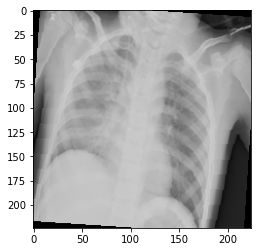

In [13]:
show_example(*train_ds[2000])

Label:  NORMAL (0)


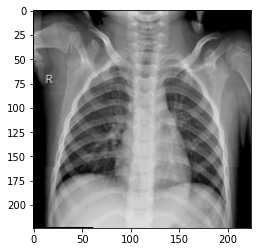

In [14]:
show_example(*train_ds[250])

In [15]:
!pip install jovian --upgrade -q
import jovian

<IPython.core.display.Javascript object>

In [39]:
jovian.commit(project="XRay classification for Pneumonia detection")

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/m-chemseddine/XRay classification for Pneumonia detection


<IPython.core.display.Javascript object>

## Training and Validation datasets

We can now create data loaders for training and validation, to load the data in batches

In [17]:
from torch.utils.data.dataloader import DataLoader

batch_size=64

In [18]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)

We can look at batches of images from the dataset using the make_grid method from torchvision. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

In [19]:
from torchvision.utils import make_grid
random_seed = 42
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

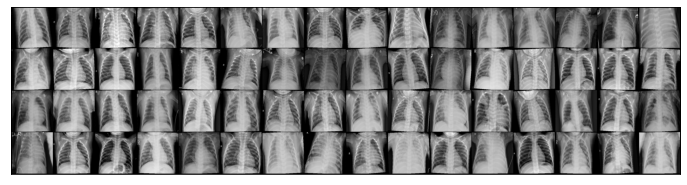

In [20]:
show_batch(train_dl)

## Using a GPU
To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required. These are described in more detail in a previous tutorial.

In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (torch.device('cpu')) or a GPU (torch.device('cuda'))

In [22]:
device = get_default_device()
device

device(type='cpu')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).

In [23]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

## Models definition

### Metrics

In [24]:
import torch.nn as nn
import torch.nn.functional as F

In [25]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [26]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Class base for models

In [32]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)
        print('loss training ok')
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        print('loss ppvalliatiion ok')
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        print('loss postvalidaation ok')
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [33]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Models list

In [29]:
class ModifiedResnet(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True


## Training the models

### Resnet

#### Training the model

In [30]:
model = to_device(ModifiedResnet(), device)
model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


ModifiedResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [34]:
evaluate(model, val_dl)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 2])) is deprecated. Please ensure they have the same size.
  # This is added back by InteractiveShellApp.init_path()


ValueError: Target and input must have the same number of elements. target nelement (128) != input nelement (256)

In [ ]:
history = [evaluate(model, valid_dl)]
history

In [ ]:
model.freeze()

In [ ]:
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

#### Plotting scores

In [ ]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');

In [ ]:
plot_scores(history)

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
plot_lrs(history)

In [ ]:
jovian.commit(project="XRay classification for Pneumonia detection")

## Testing

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

In [ ]:
img, label = test_dataset[0]
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

In [ ]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [ ]:
test_preds = predict_dl(test_dl, model)